# **Comparison of Bert-base-uncased and Spacy tokenizer on IMDB Large Movie Review Dataset**


## **1. <u>Introduction</u>**

This notebook compares the tokens produced by the **bert-base-uncased** tokenizer and the **SpaCy tokenizer** for the IMDB Dataset.


### **Brief Overview of the Dataset**

The Large Movie Review dataset is widely used for sentiment analysis, containing reviews that can be classified as positive or negative. The dataset is loaded from [Hugging Face](https://huggingface.co/datasets/stanfordnlp/imdb). For this analysis, I have selected the "training" set, which consists of 25,000 highly polar movie reviews. Out of these, 12,500 are positive reviews and 12,500 are negative reviews.


### **Brief Overview of the Approach**

In this analysis, we will follow these steps:
- **Dataset Loading**: Load the dataset and preprocess it for tokenization.
- **Tokenization**: Use both the Bert-base-uncased tokenizer and the SpaCy tokenizer to generate tokens from the reviews.
- **Entropy Calculation**: Compute the Information Value (IV) of the tokens to identify the most informative ones.
- **Top 1000 Tokens**: Extract the top 1000 tokens from both token lists based on highest IV value.
- **Comparison**: Analyze and compare the tokenization results.
- **Conclusion**: Rationale behind which tokenizer is better.

## <u>**2. Dataset Loading**</u>

In this section, we will load the dataset using the `datasets` library from `Hugging Face`. Once the dataset is loaded, we will preprocess the data for tokenization, which involves removing stop words and punctuation from the reviews.

**The rationale behind removing stop words and punctuation is that, for our downstream task of classifying reviews as positive or negative, these elements do not contribute meaningful information. However, it is important to note that stop words and punctuation can be significant in other contexts, such as predicting the next word in a sequence.**


In [140]:
# Load the IMDB movie review dataset using the datasets library
from datasets import load_dataset
ds = load_dataset("stanfordnlp/imdb")

In [141]:
# Import the pandas library for data manipulation
import pandas as pd

# Select the "train" portion of the dataset and convert it to a pandas DataFrame
df = pd.DataFrame(ds['train'])
df.head()  # Display the first 5 rows of the DataFrame

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


### **Stop word removal**

In this subsection, we will remove stop words from all the reviews using the SpaCy library. SpaCy provides a predefined set of stop words, and any words from this set that appear in the reviews will be removed. I have implemented a function called `remove_stop_words` that takes a review as input, breaks it into tokens, and checks each token to determine if it is a stop word.

In [142]:
# Import the SpaCy library
import spacy
# Creating blank language object then tokenizing words of the sentence 
nlp = spacy.blank("en") 

In [143]:
# function to check the stop words in review
def remove_stop_words(review):
    """
    Remove stop words from the given review text.

    This function tokenizes the input review using SpaCy, filters out 
    any tokens that are considered stop words, and then joins the 
    remaining tokens back into a single string.

    Parameters:
    review (str): The input review text from which stop words need to be removed.

    Returns:
    str: A string containing the review text with stop words removed.
    """

    
    doc = nlp(review)
    filtered_tokens = [token.text for token in doc if not token.is_stop]    # breaks into token and check if it is a stop word
    return " ".join(filtered_tokens)    # rejoin the remaining tokens


In [144]:
# Apply the function to the "text" column and saving the value in new column "text_filtered"
df['text_filtered'] = df['text'].apply(remove_stop_words)
df.head()

,text,label,text_filtered
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented CURIOUS - YELLOW video store controvers...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,""" Curious : Yellow "" risible pretentious steam..."
2,If only to avoid making this type of film in t...,0,avoid making type film future . film interesti...
3,This film was probably inspired by Godard's Ma...,0,"film probably inspired Godard Masculin , fémin..."
4,"Oh, brother...after hearing about this ridicul...",0,"Oh , brother ... hearing ridiculous film umpte..."


### **Punctuation removal**

In this subsection we remove the punctuation from the reviews. To achieve this I am using the `regex` library. I have written a function `remove_punctations` which substitutes the punctuation if any with empty string.

In [198]:
import re

# function to substitute the 
def remove_punctuations(review):
    
    """
    Remove punctuation from the given review text.

    This function uses a regular expression to identify and remove
    all punctuation characters from the input review, leaving only
    alphanumeric characters and whitespace.

    Parameters:
    review (str): The input review text from which punctuation needs to be removed.

    Returns:
    str: A string containing the review text with punctuation removed.
    """

    text=re.sub(r'[^\w\s]','', review)   # Remove punctuation
    return text

In [199]:
# Apply the function to the "text" column and saving the value in new column "text_filtered"
df['text_filtered'] = df['text_filtered'].apply(remove_punctuations)
df.head()

,text,label,text_filtered
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented CURIOUS YELLOW video store controversy...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,Curious Yellow risible pretentious steaming...
2,If only to avoid making this type of film in t...,0,avoid making type film future film interestin...
3,This film was probably inspired by Godard's Ma...,0,film probably inspired Godard Masculin fémini...
4,"Oh, brother...after hearing about this ridicul...",0,Oh brother hearing ridiculous film umpteen y...


### **Lowering the review**

In this subsection, we will convert all the review text to lowercase. Capitalization of words does not affect the determination of a review's positive or negative sentiment. Since the `SpaCy tokenizer` is case-sensitive, failing to convert text to lowercase can unnecessarily increase the vocabulary size, as the same word will be treated as different tokens if any characters are uppercase.

This conversion to lowercase is not necessary when using the `bert-base-uncased` model, as it is designed to ignore case distinctions. The "uncased" aspect of this model means that it treats all input text as lowercase

In [200]:
# Convert the text in the 'review' column to lowercase
df['text_filtered'] = df['text_filtered'].str.lower()
df

,text,label,text_filtered
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curious yellow video store controversy...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming...
2,If only to avoid making this type of film in t...,0,avoid making type film future film interestin...
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godard masculin fémini...
4,"Oh, brother...after hearing about this ridicul...",0,oh brother hearing ridiculous film umpteen y...
...,...,...,...
24995,A hit at the time but now better categorised a...,1,hit time better categorised australian cult fi...
24996,I love this movie like no other. Another time ...,1,love movie like time try explain virtues unin...
24997,This film and it's sequel Barry Mckenzie holds...,1,film sequel barry mckenzie holds greatest com...
24998,'The Adventures Of Barry McKenzie' started lif...,1,adventures barry mckenzie started life satir...


## <u>**3. Tokenization**</u>

In this section we will be using the `bert-base-uncased` and `SpaCy_tokenizer` for tokenizing the reviews. 

### **Bert-base-uncased**

We will load this model from the `transformers` library by `Hugging Face`. I have written a function called `bert_tokenizer` that takes a review as input and produces encodings for the review. These encodings are then converted back into tokens.

**Note**: The BERT tokenizer uses the 'CLS' and 'SEP' tokens to signify the start and end of a sentence. For our task, these tokens do not provide any useful information, so we will exclude them.



In [201]:
# importing the tokenizer and model
from transformers import AutoModel, AutoTokenizer

# model name that we choose
model_name="bert-base-uncased"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
# Load the model
model = AutoModel.from_pretrained(model_name)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [202]:
def bert_tokenizer(review):
    
    """
    Tokenize the given review text using the BERT tokenizer.

    This function takes a review as input, tokenizes it using the BERT
    tokenizer, and returns the tokens corresponding to the input IDs.
    The function removes the special tokens '[CLS]' and '[SEP]' from the output.

    Parameters:
    review (str): The input review text to be tokenized.

    Returns:
    list: A list of tokens generated by the BERT tokenizer, excluding the '[CLS]' and '[SEP]' tokens.
    """

    #Tokenize the text
    encoding = tokenizer(review, return_tensors="pt")  # Returns an Encoding object
    # Extract input_ids
    input_ids = encoding["input_ids"].squeeze().tolist()  # Convert tensor to list
    # Convert input_ids to tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids[1:-1])  # Removing the CLS and END input ids
    return tokens


# Apply the function to the "text" column and saving the value in new column "text_filtered"
df['bert_tokens'] = df['text_filtered'].apply(bert_tokenizer)
df.head()

Token indices sequence length is longer than the specified maximum sequence length for this model (535 > 512). Running this sequence through the model will result in indexing errors


,text,label,text_filtered,bert_tokens
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curious yellow video store controversy...,"[rented, curious, yellow, video, store, contro..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming...,"[curious, yellow, ri, ##sible, pre, ##ten, ##t..."
2,If only to avoid making this type of film in t...,0,avoid making type film future film interestin...,"[avoid, making, type, film, future, film, inte..."
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godard masculin fémini...,"[film, probably, inspired, god, ##ard, mas, ##..."
4,"Oh, brother...after hearing about this ridicul...",0,oh brother hearing ridiculous film umpteen y...,"[oh, brother, hearing, ridiculous, film, um, #..."


### **SpaCy Tokenizer**

In this we will be using the same tokenizer we used above to indentify the stop words.

In [203]:
def spacy_tokenizer(review):

    """
    Tokenize the given review text using the SpaCy tokenizer.

    This function takes a review as input and uses the SpaCy
    tokenizer to break the text into individual tokens.

    Parameters:
    review (str): The input review text to be tokenized.

    Returns:
    list: A list of tokens generated by the SpaCy tokenizer.
    """

    doc=nlp(review)
    tokens = [token.text for token in doc]    # breaks into token 
    return tokens 

# Apply the function to the "text" column and saving the value in new column "text_filtered"
df['spacy_tokens'] = df['text_filtered'].apply(spacy_tokenizer)
df.head()

,text,label,text_filtered,bert_tokens,spacy_tokens
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,rented curious yellow video store controversy...,"[rented, curious, yellow, video, store, contro...","[rented, curious, , yellow, video, store, con..."
1,"""I Am Curious: Yellow"" is a risible and preten...",0,curious yellow risible pretentious steaming...,"[curious, yellow, ri, ##sible, pre, ##ten, ##t...","[ , curious, , yellow, , risible, pretentiou..."
2,If only to avoid making this type of film in t...,0,avoid making type film future film interestin...,"[avoid, making, type, film, future, film, inte...","[avoid, making, type, film, future, , film, i..."
3,This film was probably inspired by Godard's Ma...,0,film probably inspired godard masculin fémini...,"[film, probably, inspired, god, ##ard, mas, ##...","[film, probably, inspired, godard, masculin, ..."
4,"Oh, brother...after hearing about this ridicul...",0,oh brother hearing ridiculous film umpteen y...,"[oh, brother, hearing, ridiculous, film, um, #...","[oh, , brother, , hearing, ridiculous, film,..."


## **4. <u>INFORMATION VALUE (IV)</u>**


In this section, we will calculate the **Information Value (IV)** of the tokens generated by the `bert-base-uncased` and `spacy tokenizer`. 

> **Information Value (IV)** is a measure used to evaluate the predictive power of a variable in distinguishing between different classes in a classification task. It quantifies how well a token (or feature) can separate the positive and negative classes based on the distribution of values within each class.

The formula to calculate IV for a given token is as follows:

$$
IV = \sum_{i=0,1} \left( P(\text{token}=i | \text{class}_1) - P(\text{token}=i | \text{class}_0) \right) \times \log\left(\frac{P(\text{token}=i | \text{class}_1)}{P(\text{token}=i | \text{class}_0)}\right)
$$

where,

$$
\text{Weight of Evidence (WoE)} = \log\left(\frac{P(\text{token}=i | \text{class}_1)}{P(\text{token}=i | \text{class}_0)}\right)
$$

IV quantifies the importance of each token in relation to predicting the associated label. This metric is class/label dependent. A higher IV value indicates that the token is more effective at distinguishing between these classes, highlighting its significance in the classification task.

### **Creating the Vocabulary**

In this subsection, we will construct a vocabulary for both tokenizers, consisting of unique tokens. To accomplish this, I have written a function called `vocab` that takes a dataframe column (either `bert_tokens` or `spacy_tokens`) as input and generates the corresponding vocabulary for us.


In [204]:
# creating the vocabulary
def vocab(corpus):
    """
    Create a vocabulary set from a given corpus of review.

    This function takes a corpus (a list of documents) and generates a set
    of unique tokens found across all documents. It ensures that each token
    is included only once in the vocabulary.

    Parameters:
    corpus (list of list): A list where each element is a document represented
                            as a list of tokens.

    Returns:
    set: A set of unique tokens extracted from the entire corpus.
    """

    vocab=set()
    for doc in corpus:
        unique_token=set(doc)
        vocab.update(unique_token)
    return vocab



bert_vocab=vocab(df['bert_tokens'])     # BERT vocab
spacy_vocab=vocab(df['spacy_tokens'])   # SPACY vocab

### **Counter of occurence in positive and negative reviews**

In this subsection, we will count the occurrences of each token in both positive and negative reviews, as well as their non-occurrences in each category. To achieve this, I have implemented the `pos_neg_token_count` function. This function takes a dataframe column (either `bert_tokens` or `spacy_tokens`) and its corresponding vocabulary as inputs, and it returns a count of the tokens, detailing their presence in positive and negative reviews.


In [96]:
def pos_neg_token_count(col_name,vocab):

    """
    Count the occurrences of tokens in positive and negative reviews.

    This function takes a column name {bert_tokens, spacy_tokens} and a 
    vocabulary set, then calculates the count of occurrences of each token 
    in both positive and negative reviews. It returns a dictionary where each 
    token is associated with its counts in positive and negative contexts.

    Parameters:
    col_name (str): The name of the DataFrame column containing tokenized reviews.
    vocab (set): A set of unique tokens to analyze.

    Returns:
    dict: A dictionary where keys are tokens and values are tuples containing
          the counts of positive occurrences,  the count of non-occurrences in 
          positive reviews, negative occurrences, and the count of non-occurrences 
          in negative reviews.
    """

    num_pos_review=len(df['label']==1)  # number of positive review
    num_neg_review=len(df['label']==0)  # number of negative review

    counter={}
    for token in tqdm(list(vocab), desc=f"Processing {col_name}"):

        #count of occurrences in positive reviews
        positive_count = df[col_name][df['label'] == 1].apply(lambda x: token in x).sum()
        #count of occurrences in negative reviews
        negative_count = df[col_name][df['label'] == 0].apply(lambda x: token in x).sum()
        counter[token] = (positive_count, num_pos_review - positive_count, negative_count, num_neg_review - negative_count)
    
    return counter


counter_bert_tokens=pos_neg_token_count('bert_tokens', bert_vocab)    # Counter for BERT
counter_spacy_tokens=pos_neg_token_count('spacy_tokens', spacy_vocab)  # Counter for SpaCy

Processing spacy_tokens: 100%|██████████| 89062/89062 [51:10<00:00, 29.01it/s]  


### **IV calculation**

In this subsection, we will compute the Information Value (IV) using the formula outlined earlier. I have implemented the `iv_calculated function`, which takes the vocabulary, a counter of token occurrences, and the total number of positive and negative reviews as inputs. This function returns the IV values for all tokens in the vocabulary.

In [106]:
def iv_calculated(vocab, counter, num_pos_review, num_neg_review):
    
    """
    Calculate the Information Value (IV) for each token in the vocabulary.

    This function computes the IV for a given set of tokens based on their
    occurrences in positive and negative reviews. It uses the Weight of Evidence 
    (WoE) to quantify the predictive power of each token in distinguishing between 
    the two classes.

    Parameters:
    vocab (set): A set of unique tokens for which to calculate IV.
    counter (dict): A dictionary containing counts of token occurrences in positive 
                    and negative reviews. The structure is {token: (positive_count, 
                    non_positive_count, negative_count, non_negative_count)}.

    num_pos_review (int): The total number of positive reviews.
    num_neg_review (int): The total number of negative reviews.

    Returns:
    dict: A dictionary where keys are tokens and values are their corresponding 
          Information Value (IV) scores.
    """

    iv={}
    for token in tqdm(list(vocab), desc=f"Processing"):
   
        positive_count=counter[token][0]      # no. of times token present in positive class
        non_positive_count=counter[token][1]  # no. of times token not present in positive class
        negative_count=counter[token][2]      # no. of times token present in negative class
        non_negative_count=counter[token][3]    # no. of times token not present in negative class


        if positive_count == 0 or negative_count==0:
            woe=np.log((non_positive_count / num_pos_review) / (non_negative_count / num_neg_review))  # cal WOE for not occurence
            iv[token]=(non_positive_count / num_pos_review - negnon_negative_count_ / num_neg_review) * woe  # cal IV for not occurence
            iv[token]=iv[token].item()            
        
        else:
            woe = np.log((positive_count / num_pos_review) / (negative_count / num_neg_review))  #cal WOE for occurence
            iv[token]= (positive_count / num_pos_review - negative_count / num_neg_review) * woe  # cal IV for occurence

            woe=np.log((non_positive_count / num_pos_review) / (non_negative_count / num_neg_review))  # cal woe for not occurence
            iv[token]+=(non_positive_count / num_pos_review - non_negative_count / num_neg_review) * woe  # cal IV for not occurence
            iv[token]=iv[token].item()
        

    return iv


num_pos_review=len(df['label']==1)    # number of positive review
num_neg_review=len(df['label']==0)    # number of negative review

bert_IV=iv_calculated(bert_vocab, counter_bert_tokens, num_pos_review, num_neg_review)    # BERT tokens IV
spacy_IV=iv_calculated(spacy_vocab, counter_spacy_tokens, num_pos_review, num_neg_review)  # SpaCy tokens IV
    

Processing: 100%|██████████| 89062/89062 [00:00<00:00, 668522.70it/s]


## **5. <u>Top 1000 tokens</u>**

In this section, we will extract the top 1000 tokens based on the Information Value (IV) calculated for both tokenizers. We will sort the IV values in descending order, as a higher IV indicates that a token is more important for predicting labels.

In [130]:
# sorting in descendin order, extracting the top 1000 token with IV value
bert_top1000=sorted(bert_IV.items(), key=lambda item: item[1], reverse=True)[:1000]
spacy_top1000=sorted(spacy_IV.items(), key=lambda item: item[1], reverse=True)[:1000]

# keepin the top 1000 tokens
top_1000_bert_token= set([item[0] for item in bert_top1000[:1000]])
top_1000_spacy_token= set([item[0] for item in spacy_top1000[:1000]])


## **6. <u>Comparison</u>**

In this section, we will compare the two lists of tokens using various metrics and visualizations. One of the key metrics employed is the **Jaccard Similarity**, which quantifies the ratio of common words to the total number of unique words in both lists. This can also be referred to as the Overlap Ratio.

### **Jaccard Similarity**

The Jaccard Similarity is calculated using the formula -:

$$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$$

where:
-  J(A, B)  is the Jaccard Similarity between sets \( A \) and \( B \).
-  |A ∩ B|  is the number of common elements between sets \( A \) and \( B \) (intersection).
- |A U B|  is the total number of unique elements in both sets \( A \) and \( B \) (union).


In [159]:
# number of common words
common_words = len(top_1000_spacy_token.intersection(top_1000_bert_token))
print(f"The number of tokens common in both list are {common_words}")

# total words (union of 2 set)
total=len(top_1000_spacy_token.union(top_1000_bert_token))

#Jaccard Similarity
jaccard_similarity = common_words / total
print(f"The Jaccard similarity value is {jaccard_similarity}")

The number of tokens common in both list are 752
The Jaccard similarity value is 0.6025641025641025


### **Unique word count**

In [160]:
# Find uncommon words
unique_spacy_token = top_1000_spacy_token - top_1000_bert_token   # present in spacy but not in bert
unique_bert_token = top_1000_bert_token - top_1000_spacy_token     # present in bert but not in spacy

uncommon_token_num =len(unique_spacy_token)

print(f"The number of tokens unique in Spacy/Bert list are {uncommon_token_num}")

The number of tokens unique in Spacy/Bert list are 248


### **Visualization**

In this subsection, we will plot the word cloud of the words that are p. For this I am using the `worldcloud` library.

In [161]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [185]:
def word_cloud(text, title):

    """
    Generate and display a word cloud from the provided text.

    This function creates a visual representation of the words
    in the input text, using the WordCloud library. It allows 
    for customization of the plot's title and the appearance of
    the word cloud.

    Parameters:
    text (str): The input text from which to generate the word cloud. 
                It should consist of words separated by spaces.
    title (str): The title to display above the word cloud plot.

    Returns:
    None: This function does not return a value but displays the word cloud plot.

    """

    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    # Plot the word cloud
    plt.figure(figsize=(12, 8))  # Adjust the figure size for better aspect ratio
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off the axis

    # Center the word cloud
    plt.tight_layout(pad=0)

    # add title
    plt.title(title, fontsize=30, fontweight='bold')
    
    # Show the plot
    plt.show()

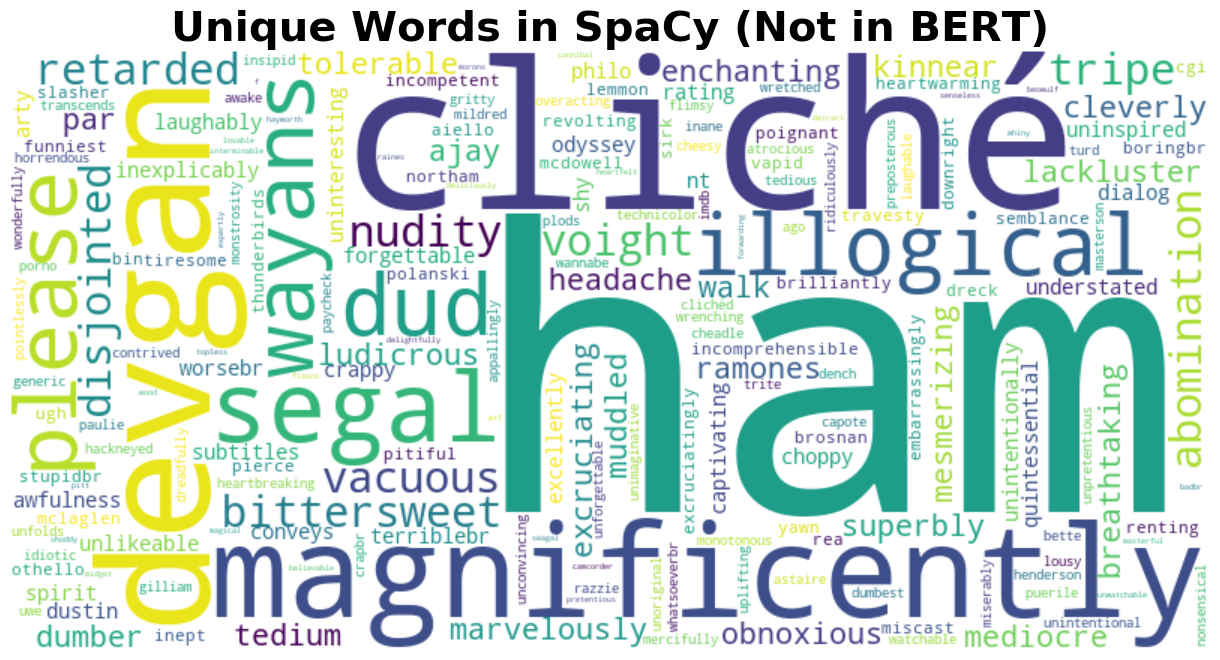

In [186]:
word_cloud(" ".join(unique_spacy_token), "Unique Words in SpaCy (Not in BERT)")

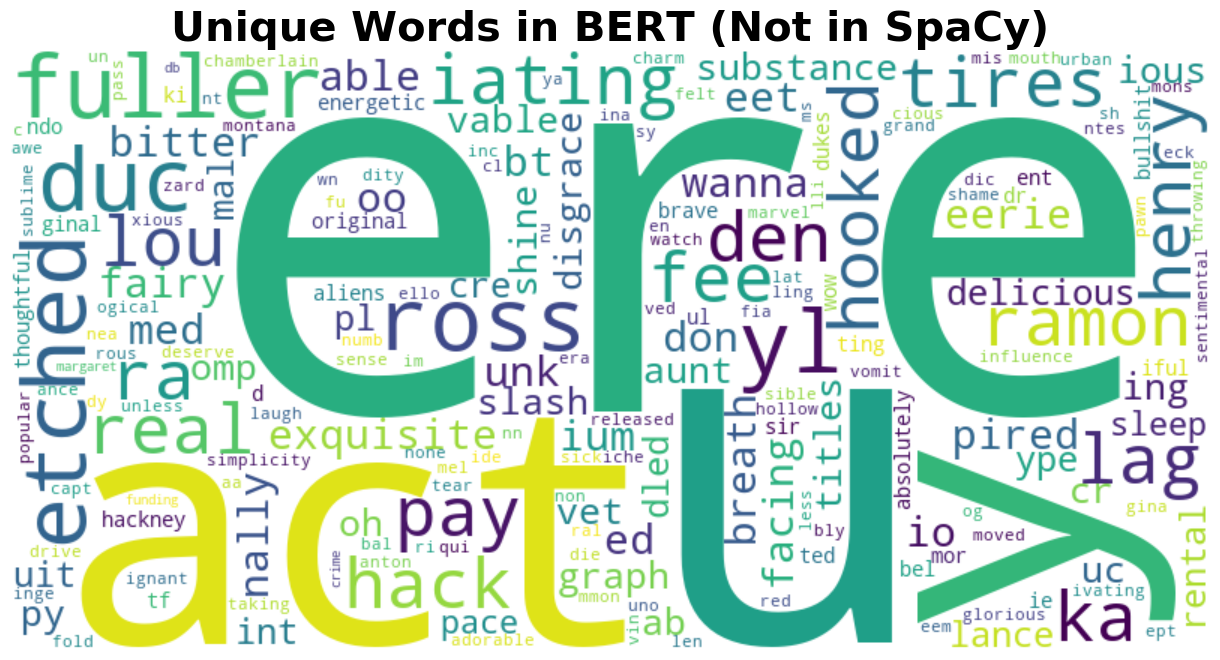

In [211]:
word_cloud(" ".join(unique_bert_token), "Unique Words in BERT (Not in SpaCy)")

## **7.** <u>**Conclusion**</u>

## **BERT is better** 

The Jaccard similarity value of 0.602 indicates a moderate overlap between the two token lists. Out of 1,000 tokens, 752 are shared, signifying their presence in the 30,000 fixed-size vocabulary of the BERT-based uncased tokenizer. Thus, these tokens can be categorized as general or commonly used words.

Among the remaining 248 words in the BERT-based uncased tokens list, many are in their root forms, such as "act," "shine," and "marvel." In contrast, the SpaCy token list features longer variations like "magnificently," "illogical," and "retarded." This suggests that SpaCy considers unnecessary tokens for words that are combinations of root forms with various suffixes. Consequently, this expansion of the vocabulary size complicates computations, as it requires a larger lookup table for embeddings.



### **Does This Align with My Intuition?**

Yes, it aligns with my intuition. Here, we used the SpaCy blank English language tokenizer, which relies on rule-based tokenization based on whitespace and punctuation. Since this tokenizer does not operate with a fixed vocabulary, it treats each distinct word as a unique token. This leads to an increased vocabulary size, as even minor variations in wording are considered separate tokens.

### **Rationale for choosing BERT Tokenizer for the sentiment classification task**

- One of the primary advantages of using the BERT tokenizer during the testing phase of the movie review classification task is its effective handling of out-of-vocabulary (OOV) words. Unlike the SpaCy tokenizer, which may trigger errors for OOV words unless explicitly managed (such as by substituting them with an UNKNOWN token), the BERT tokenizer employs subword tokenization. This allows even unfamiliar words to be broken down into recognizable subword units, ensuring efficient processing by the model.


- The BERT uncased tokenizer uses a fixed vocabulary of approx 30k tokens. This is in contrast to SpaCy’s blank ('en') tokenizer, which dynamically constructs a vocabulary from the corpus using tokenization rules. SpaCy's approach can result in a significantly larger and sparser vocabulary, leading to increased model complexity and potential inefficiencies.The BERT tokenizer generates fewer unique tokens due to its subword approach, whereas the SpaCy tokenizer inflates the vocabulary size with numerous unique tokens. This leads to enhanced model efficiency and reduced training complexity for BERT.

- The BERT-based uncased tokenizer requires less preprocessing compared to the SpaCy blank ('en') tokenizer. For instance, the BERT tokenizer automatically manages case sensitivity, eliminating the need for manual lowercasing of text.